In [1]:
## Image Denoising with AutoEncoders

In [ ]:
#importing libraries

In [4]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [5]:
#data preprocessing

In [6]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.
x_train = np.reshape(x_train, (60000,784))
x_test = np.reshape(x_test, (10000,784))

In [7]:
# Adding Noise


In [8]:
x_train_noisy = x_train + np.random.rand(60000,784)*0.9
x_test_noisy = x_test + np.random.rand(10000,784)*0.9

x_train_noisy =  np.clip(x_train_noisy , 0.,1.)
x_test_noisy =  np.clip(x_test_noisy , 0.,1.)

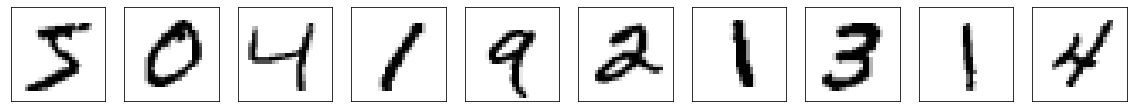

In [9]:
#plot Function

def plot(x, p, labels=False):
  plt.figure(figsize=(20,2))
  for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x[i].reshape(28,28),cmap = 'binary')
    plt.xticks([])
    plt.yticks([])
    if labels:
      plt.xlabel(np.argmax(p[i]))
  plt.show()

plot(x_train, None)

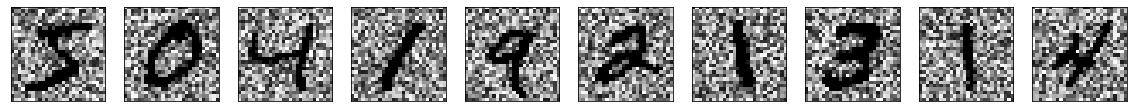

In [10]:
plot(x_train_noisy, None)

In [11]:
 ## Building and Training a Classifier

In [12]:
classifier =  Sequential([
        Dense(256, activation='relu', input_shape=(784,)),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')

])

classifier.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

classifier.fit(x_train, y_train, batch_size=512, epochs =3)

Epoch 1/3
118/118 [==============================] - 2s 16ms/step - loss: 0.4236 - accuracy: 0.8855
Epoch 2/3
118/118 [==============================] - 2s 16ms/step - loss: 0.1560 - accuracy: 0.9536
Epoch 3/3
118/118 [==============================] - 2s 16ms/step - loss: 0.1048 - accuracy: 0.9692


In [13]:
loss,acc= classifier.evaluate(x_test,y_test)
print(acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.1012 - accuracy: 0.9698
0.9697999954223633


In [15]:
#Classifier doesn't work at all with Noisy data

loss, acc= classifier.evaluate(x_test_noisy, y_test)
print(acc)

313/313 [==============================] - 0s 1ms/step - loss: 10.6935 - accuracy: 0.1278
0.12780000269412994


In [16]:
##Building the autoencoder

In [18]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss = 'binary_crossentropy', optimizer= 'adam')

In [19]:
##Training the autoencoder

In [22]:
#denoise data
autoencoder.fit(
    x_train_noisy, x_train, epochs =100,
    batch_size=512, validation_split = 0.2, verbose =False,
    callbacks=[
               EarlyStopping(monitor='val_loss', patience=5),
               LambdaCallback(on_epoch_end=lambda e, l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print(' _ ')
print('Training is Complete!')

0.238 _ 0.205 _ 0.187 _ 0.175 _ 0.166 _ 0.158 _ 0.152 _ 0.146 _ 0.142 _ 0.137 _ 0.134 _ 0.130 _ 0.128 _ 0.126 _ 0.124 _ 0.122 _ 0.121 _ 0.120 _ 0.119 _ 0.118 _ 0.117 _ 0.116 _ 0.115 _ 0.115 _ 0.114 _ 0.114 _ 0.113 _ 0.113 _ 0.113 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.110 _ 0.110 _ 0.110 _ 0.111 _ 0.110 _ 0.110 _ 0.111 _  _ 
Training is Complete!


In [23]:
predictions = autoencoder.predict(x_test_noisy)

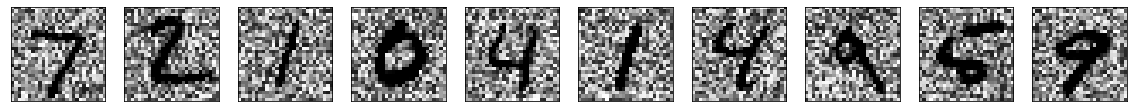

In [24]:
plot(x_test_noisy, None)

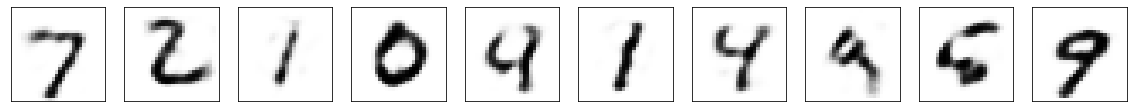

In [25]:
plot(predictions, None)

In [27]:
loss, acc = classifier.evaluate(predictions, y_test)
print(acc)

# This is better than the results achieved without denoising the data in Cell 15

313/313 [==============================] - 0s 2ms/step - loss: 0.1883 - accuracy: 0.9400
0.9399999976158142


In [28]:
##Composite Model

In [29]:
#This model will input images and denoise them and then putput the correct prediction. This model will work for both noisy and non-noisy images.


input_image= Input(shape=(784,))
x=autoencoder(input_image)
y = classifier(x)

denoise_and_classify= Model(input_image,y)

In [30]:
predictions = denoise_and_classify.predict(x_test_noisy)

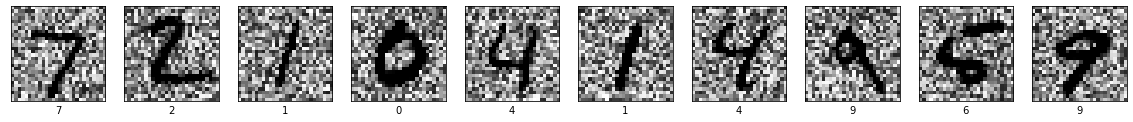

In [31]:
plot(x_test_noisy, predictions, True)

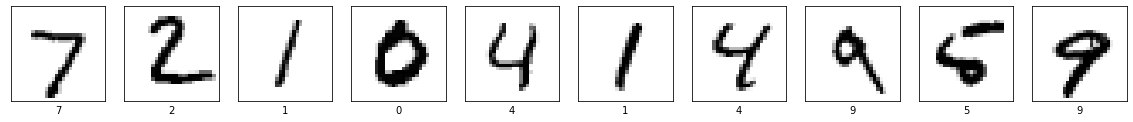

In [32]:
plot(x_test, to_categorical(y_test), True)